In [1]:
# === Next-Year Discount Optimization Plan — SELF-CONTAINED (Jupyter) ===
# Bu hücre "data" yoksa onu oluşturur ve sonra gelecek yıl planını çıkarır.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

# ---------- CONFIG ----------
CSV_PATH        = "globalsales_profit_iqr_cleaned.csv"   # gerekirse değiştirin
DATE_COL        = "date_formatted"
DAYNAME_COL     = "day_name"
PRODUCT_COL     = "product"
# Sizden gelen ürün ikilileri:
PRODUCT_BINARIES = [
    "product_paseo", "product_amarilla", "product_velo",
    "product_vtt", "product_carretera", "product_montana"
]

SALE_PRICE_COL  = "sale_price"          # liste fiyatı (indirim öncesi fiyat)
DISCOUNT_COL    = "discount_rate_pct"   # [0,1]
COGS_COL        = "cogs"

# Units (adet) sütunu yoksa oto-tespit/çıkarma yapılır
CANDIDATE_UNITS   = ["unit_sold","units_sold","units","qty","quantity","order_qty","sold_units","ordered_units"]
CANDIDATE_REVENUE = ["sales","revenue","net_sales","gross_sales","order_revenue","amount"]

# Türetilen sütun adları
LIST_PRICE_COL = "list_price"
UNIT_COST_COL  = "unit_cost"
PROFIT_COL     = "profit"
UNITS_COL      = "_units"   # model hedefi

# Senaryo varsayımları (gelecek yıl)
PRICE_GROWTH_PCT = 0.00
COST_GROWTH_PCT  = 0.00
INCLUDE_WEEKENDS = True

# İndirim ızgarası
MIN_DISC, MAX_DISC = 0.00, 0.50
STEP_COARSE, STEP_FINE = 0.05, 0.01

OUTPUT_CSV = "next_year_discount_plan.csv"
# ---------------------------


# ---------- Yardımcılar ----------
def discount_grid(min_disc=MIN_DISC, max_disc=MAX_DISC, step_coarse=STEP_COARSE, step_fine=STEP_FINE):
    coarse = np.round(np.arange(min_disc, max_disc + 1e-9, step_coarse), 4)
    fine   = np.round(np.arange(min_disc, min(max_disc, 0.30) + 1e-9, step_fine), 4)
    return np.unique(np.concatenate([coarse, fine]))

def expected_profit(units, price, cost, disc):
    margin = max(price * (1.0 - disc) - cost, 0.0)
    return units * margin

def _to_num01(s):
    x = pd.to_numeric(s, errors="coerce")
    if x.isna().all():
        mapped = s.astype(str).str.strip().str.lower().map(
            {"1":1,"true":1,"yes":1,"y":1,"t":1,"0":0,"false":0,"no":0,"n":0,"f":0}
        )
        x = pd.to_numeric(mapped, errors="coerce")
    return (x.fillna(0) > 0.5).astype(int)

def derive_product(df):
    if PRODUCT_COL in df.columns:
        return df
    miss = [c for c in PRODUCT_BINARIES if c not in df.columns]
    if miss:
        raise ValueError(f"Eksik product_* sütunları: {miss}")
    out = df.copy()
    for c in PRODUCT_BINARIES: out[c] = _to_num01(out[c])
    def pick(row):
        for p in PRODUCT_BINARIES:
            if row[p] == 1: return p
        return np.nan
    out[PRODUCT_COL] = out.apply(pick, axis=1)
    return out.dropna(subset=[PRODUCT_COL])

def find_units_or_derive(df):
    # 1) Aday adlar
    for cand in CANDIDATE_UNITS:
        if cand in df.columns:
            u = pd.to_numeric(df[cand], errors="coerce").fillna(0.0)
            print(f"[INFO] Units kolonu bulundu: {cand}")
            return u.clip(lower=0.0)
    # 2) Cirodan çıkar (revenue / (sale_price*(1-discount)))
    rev_col = next((c for c in CANDIDATE_REVENUE if c in df.columns), None)
    if rev_col is not None and SALE_PRICE_COL in df.columns and DISCOUNT_COL in df.columns:
        revenue = pd.to_numeric(df[rev_col], errors="coerce").fillna(0.0)
        price   = pd.to_numeric(df[SALE_PRICE_COL], errors="coerce").fillna(0.0)
        disc    = pd.to_numeric(df[DISCOUNT_COL], errors="coerce").fillna(0.0).clip(MIN_DISC, MAX_DISC)
        denom   = (price * (1.0 - disc)).replace(0, np.nan)
        units   = (revenue / denom).replace([np.inf,-np.inf], np.nan).fillna(0.0)
        print(f"[INFO] Units cirodan türetildi: {rev_col}")
        return units.clip(lower=0.0)
    raise ValueError("Units kolonu bulunamadı ve cirosundan türetilemedi.")

def prepare_data(df):
    df = df.copy()
    # Zorunlu kolonlar
    need = [DATE_COL, DAYNAME_COL, SALE_PRICE_COL, DISCOUNT_COL, COGS_COL]
    miss = [c for c in need if c not in df.columns]
    if miss: raise ValueError(f"Eksik zorunlu kolonlar: {miss}")

    # product üret
    df = derive_product(df)

    # list_price = sale_price
    df[LIST_PRICE_COL] = pd.to_numeric(df[SALE_PRICE_COL], errors="coerce")

    # units
    units = find_units_or_derive(df)

    # unit_cost = cogs / units (güvenli)
    num = pd.to_numeric(df[COGS_COL], errors="coerce")
    den = units.replace(0, np.nan)
    df[UNIT_COST_COL] = (num / den).replace([np.inf,-np.inf], np.nan)
    med_cost = df[UNIT_COST_COL].median(skipna=True)
    df[UNIT_COST_COL] = df[UNIT_COST_COL].fillna(0.0 if not np.isfinite(med_cost) else med_cost)

    # discount clamp
    df[DISCOUNT_COL] = pd.to_numeric(df[DISCOUNT_COL], errors="coerce").clip(MIN_DISC, MAX_DISC).fillna(0.0)

    # profit (yoksa)
    if PROFIT_COL not in df.columns:
        margin = df[LIST_PRICE_COL]*(1 - df[DISCOUNT_COL]) - df[UNIT_COST_COL]
        df[PROFIT_COL] = units * np.maximum(margin, 0.0)

    # hedef
    df[UNITS_COL] = units

    # tarih
    if not np.issubdtype(df[DATE_COL].dtype, np.datetime64):
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df

def build_pipeline_for_future(df):
    cat_cols = [DAYNAME_COL, PRODUCT_COL]
    num_cols = [DISCOUNT_COL, LIST_PRICE_COL, UNIT_COST_COL]
    pre = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ])
    # GradientBoostingRegressor: scikit-learn dokümantasyonına göre regresyon için güçlü bir temel yöntemdir.
    # (bkz. docs) :contentReference[oaicite:2]{index=2}
    model = GradientBoostingRegressor(n_estimators=600, learning_rate=0.03, max_depth=3, random_state=42)
    pipe = Pipeline([("pre", pre), ("model", model)])
    return pipe, cat_cols + num_cols

def optimize_row(pipe, feature_cols, row_like_df, price, cost):
    best_p, best_d, best_u = -1e18, 0.0, 0.0
    for d in discount_grid():
        Xd = row_like_df[feature_cols].copy()
        Xd = Xd.copy()
        Xd[DISCOUNT_COL] = d
        u = float(pipe.predict(Xd)[0]); u = max(u, 0.0)
        p = expected_profit(u, price, cost, d)
        if p > best_p:
            best_p, best_d, best_u = p, d, u
    return best_d, best_u, best_p
# ------------------------------


# ---------- 0) Eğer data yoksa oluştur ----------
if "data" not in globals():
    print("[INFO] 'data' tanımlı değil; CSV'den oluşturuluyor...")
    raw = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL], low_memory=False)
    data = prepare_data(raw)
else:
    # data varsa asgari kolon kontrolü
    need = [DATE_COL, DAYNAME_COL, PRODUCT_COL, DISCOUNT_COL, LIST_PRICE_COL, UNIT_COST_COL, UNITS_COL]
    miss = [c for c in need if c not in data.columns]
    if miss:
        print("[WARN] 'data' var ama eksik kolonlar bulundu; CSV'den yeniden hazırlanıyor:", miss)
        raw = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL], low_memory=False)
        data = prepare_data(raw)

# ---------- 1) Tüm geçmişle modeli fit et ----------
pipe, FEATS = build_pipeline_for_future(data)
pipe.fit(data[FEATS], data[UNITS_COL])

# ---------- 2) Gelecek yıl takvim × ürünler ----------
last_date = pd.to_datetime(data[DATE_COL]).max()
future_year = (last_date + pd.Timedelta(days=1)).year
start = pd.Timestamp(year=future_year, month=1, day=1)
end   = pd.Timestamp(year=future_year, month=12, day=31)
all_days = pd.date_range(start, end, freq="D")
if not INCLUDE_WEEKENDS:
    all_days = all_days[all_days.weekday < 5]  # Mon=0..Sun=6

future = pd.DataFrame({DATE_COL: all_days})
future[DAYNAME_COL] = future[DATE_COL].dt.day_name()

# Ürünlerle çapraz çarpım (pandas >=1.2 'how=\"cross\"' destekler). :contentReference[oaicite:3]{index=3}
products = np.sort(data[PRODUCT_COL].unique())
future = future.merge(pd.DataFrame({PRODUCT_COL: products}), how="cross")

# ---------- 3) Ürün başına fiyat/maliyet varsayımları ----------
prod_price = data.groupby(PRODUCT_COL)[LIST_PRICE_COL].median().rename("hist_price_med")
prod_cost  = data.groupby(PRODUCT_COL)[UNIT_COST_COL].median().rename("hist_cost_med")
future = future.merge(prod_price, on=PRODUCT_COL, how="left").merge(prod_cost, on=PRODUCT_COL, how="left")

future[LIST_PRICE_COL] = future["hist_price_med"] * (1.0 + PRICE_GROWTH_PCT)
future[UNIT_COST_COL]  = future["hist_cost_med"]  * (1.0 + COST_GROWTH_PCT)
future[DISCOUNT_COL]   = 0.0  # placeholder

# ---------- 4) Satır bazında indirim optimizasyonu ----------
opt_d, opt_u, opt_p = [], [], []
for i in range(len(future)):
    r = future.iloc[i:i+1].copy()
    price = float(r[LIST_PRICE_COL].iloc[0]); cost  = float(r[UNIT_COST_COL].iloc[0])
    d, u, p = optimize_row(pipe, FEATS, r, price, cost)
    opt_d.append(d); opt_u.append(u); opt_p.append(p)

future["recommended_discount"] = np.array(opt_d)
future["pred_units"]          = np.array(opt_u)
future["expected_profit"]     = np.array(opt_p)
future["expected_revenue"]    = future["pred_units"] * future[LIST_PRICE_COL] * (1.0 - future["recommended_discount"])
future["unit_margin"]         = np.maximum(future[LIST_PRICE_COL]*(1.0 - future["recommended_discount"]) - future[UNIT_COST_COL], 0.0)

# ---------- 5) Kaydet + özet ----------
future_out_cols = [
    DATE_COL, DAYNAME_COL, PRODUCT_COL, LIST_PRICE_COL, UNIT_COST_COL,
    "recommended_discount", "pred_units", "expected_profit", "expected_revenue", "unit_margin"
]
future[future_out_cols].to_csv(OUTPUT_CSV, index=False)

summary_next = future.groupby(PRODUCT_COL, as_index=False).agg(
    days=("recommended_discount","count"),
    avg_discount=("recommended_discount","mean"),
    units=("pred_units","sum"),
    revenue=("expected_revenue","sum"),
    profit=("expected_profit","sum"),
)

display(summary_next.sort_values("profit", ascending=False).head(10))
print(f"Saved next-year plan to: {OUTPUT_CSV}")
print(f"Year planned: {future_year}  |  Days: {len(all_days)}  |  Products: {len(products)}")


[INFO] 'data' tanımlı değil; CSV'den oluşturuluyor...
[INFO] Units kolonu bulundu: units_sold


,product,days,avg_discount,units,revenue,profit
4,product_velo,365,0.034274,697311.266728,1.344517e+07,6.472061e+06
5,product_vtt,365,0.039973,668450.808092,1.282798e+07,6.143470e+06
3,product_paseo,365,0.044247,727926.217515,1.043741e+07,3.158147e+06
2,product_montana,365,0.055671,757381.438950,1.071843e+07,3.144620e+06
1,product_carretera,365,0.057068,738123.433314,1.039180e+07,3.010568e+06
0,product_amarilla,365,0.066986,698434.108256,9.663114e+06,2.678773e+06


Saved next-year plan to: next_year_discount_plan.csv
Year planned: 2014  |  Days: 365  |  Products: 6


In [2]:
# Eğer önceki hücrelerinizde pipe ve FEATS hâlâ bellekteyse bu hücreyi atlayabilirsiniz.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

# Gerekli sütun adlarının mevcut olduğunu varsayıyoruz
cat_cols = [DAYNAME_COL, PRODUCT_COL]
num_cols = [DISCOUNT_COL, LIST_PRICE_COL, UNIT_COST_COL]

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])
pipe = Pipeline([("pre", pre),
                 ("model", GradientBoostingRegressor(n_estimators=600, learning_rate=0.03, max_depth=3, random_state=42))])

# Modeli TÜM tarihsel veride `_units` hedefiyle yeniden eğitelim:
pipe.fit(data[cat_cols + num_cols], data["_units"].values)
FEATS = cat_cols + num_cols

# Ortak yardımcılar (gelecek yıl için de aynı ızgara)
def discount_grid(min_disc=0.0, max_disc=0.50, step_coarse=0.05, step_fine=0.01):
    coarse = np.round(np.arange(min_disc, max_disc+1e-9, step_coarse), 4)
    fine   = np.round(np.arange(min_disc, min(max_disc, 0.30)+1e-9, step_fine), 4)
    return np.unique(np.concatenate([coarse, fine]))

def expected_profit(units, price, cost, disc):
    margin = max(price * (1.0 - disc) - cost, 0.0)
    return units * margin


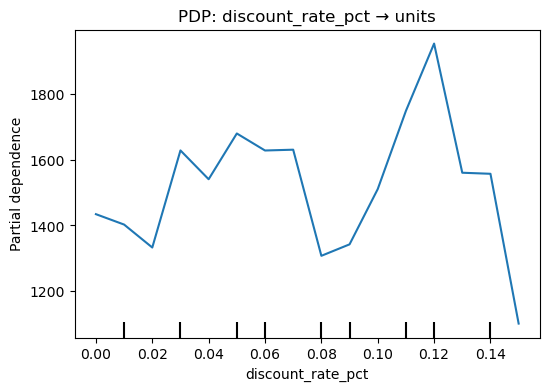

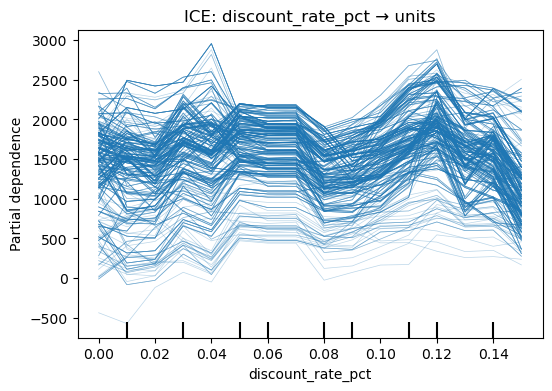

In [3]:
from sklearn.inspection import PartialDependenceDisplay

X_sample = data[FEATS]  # tarihsel özellik uzayı
fig = plt.figure(figsize=(6,4)); ax = plt.gca()
PartialDependenceDisplay.from_estimator(pipe, X_sample, features=[FEATS.index(DISCOUNT_COL)], kind="average", ax=ax)
ax.set_title("PDP: discount_rate_pct → units")
plt.show()

fig = plt.figure(figsize=(6,4)); ax = plt.gca()
PartialDependenceDisplay.from_estimator(pipe, X_sample, features=[FEATS.index(DISCOUNT_COL)], kind="individual", ax=ax)
ax.set_title("ICE: discount_rate_pct → units")
plt.show()


Baseline RMSE: 913.8966


,feature,importance,std
0,day_name,72045.034180,48787.249479
3,list_price,67037.320182,33702.395922
2,discount_rate_pct,47462.953954,49997.983025
4,unit_cost,20243.903671,26107.942101
1,product,-27927.274705,22369.561361


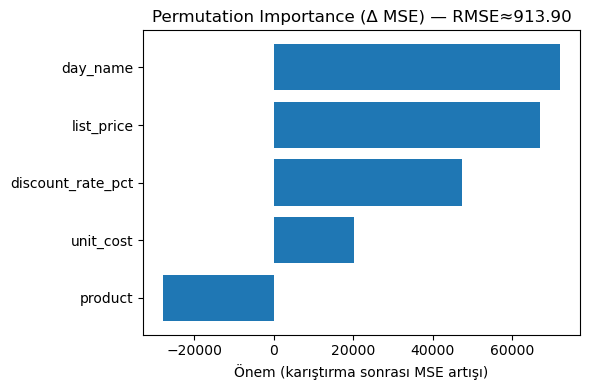

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

# küçük bir hold-out parça (zamansal tutarlılık gerekirse son split'in test setini de kullanabilirsiniz)
idx_train, idx_test = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42, shuffle=True)
Xtr, ytr = data.iloc[idx_train][FEATS], data.iloc[idx_train]["_units"].values
Xte, yte = data.iloc[idx_test][FEATS],  data.iloc[idx_test]["_units"].values

pipe.fit(Xtr, ytr)
pred = pipe.predict(Xte)
baseline_rmse = np.sqrt(mean_squared_error(yte, pred))  # squared=False yoksa bu şekilde

pi = permutation_importance(
    pipe, Xte, yte,
    n_repeats=10, random_state=42,
    scoring="neg_mean_squared_error"  # neg_root_mean_squared_error yoksa uyumlu seçenek
)

imp_df = pd.DataFrame({
    "feature": FEATS,
    "importance": pi.importances_mean,
    "std": pi.importances_std
}).sort_values("importance", ascending=False)

print(f"Baseline RMSE: {baseline_rmse:.4f}")
display(imp_df)

plt.figure(figsize=(6,4))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.gca().invert_yaxis()
plt.title(f"Permutation Importance (Δ MSE) — RMSE≈{baseline_rmse:.2f}")
plt.xlabel("Önem (karıştırma sonrası MSE artışı)")
plt.tight_layout(); plt.show()


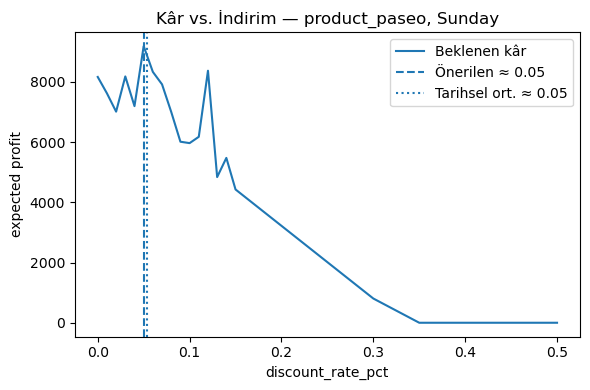

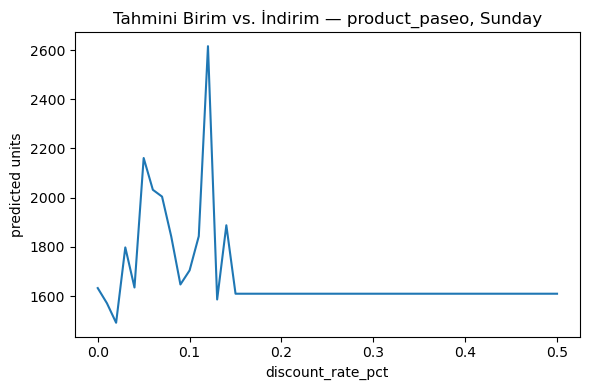

In [5]:
# Segment seçimi
prod = data[PRODUCT_COL].mode().iloc[0]     # isterseniz belirli SKU girin
wday = data[DAYNAME_COL].mode().iloc[0]

seg_hist = data[(data[PRODUCT_COL]==prod) & (data[DAYNAME_COL]==wday)]
seg_fut  = future[(future[PRODUCT_COL]==prod) & (future[DAYNAME_COL]==wday)]

# Temsilî fiyat/maliyet (gelecek yıl planındaki medyanlar)
price = float(seg_fut[LIST_PRICE_COL].median())
cost  = float(seg_fut[UNIT_COST_COL].median())
dgrid = discount_grid()

# Temsilî gözlem
Xrep = pd.DataFrame({
    DAYNAME_COL: [wday],
    PRODUCT_COL: [prod],
    DISCOUNT_COL: [0.0],
    LIST_PRICE_COL: [price],
    UNIT_COST_COL: [cost]
})

units_curve, profit_curve = [], []
for d in dgrid:
    Xrep_d = Xrep.copy()
    Xrep_d[DISCOUNT_COL] = d
    u = float(pipe.predict(Xrep_d[FEATS])[0]); u = max(u, 0.0)
    units_curve.append(u)
    profit_curve.append(expected_profit(u, price, cost, d))

best_idx = int(np.argmax(profit_curve))
best_d   = float(dgrid[best_idx])
best_p   = float(profit_curve[best_idx])

# Geçmişteki ortalama indirim (aynı segment)
curr_avg_d = float(seg_hist[DISCOUNT_COL].mean()) if len(seg_hist) else np.nan

plt.figure(figsize=(6,4))
plt.plot(dgrid, profit_curve, label="Beklenen kâr")
plt.axvline(best_d, linestyle="--", label=f"Önerilen ≈ {best_d:.2f}")
if not np.isnan(curr_avg_d):
    plt.axvline(curr_avg_d, linestyle=":", label=f"Tarihsel ort. ≈ {curr_avg_d:.2f}")
plt.title(f"Kâr vs. İndirim — {prod}, {wday}")
plt.xlabel("discount_rate_pct"); plt.ylabel("expected profit")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(dgrid, units_curve)
plt.title(f"Tahmini Birim vs. İndirim — {prod}, {wday}")
plt.xlabel("discount_rate_pct"); plt.ylabel("predicted units")
plt.tight_layout(); plt.show()


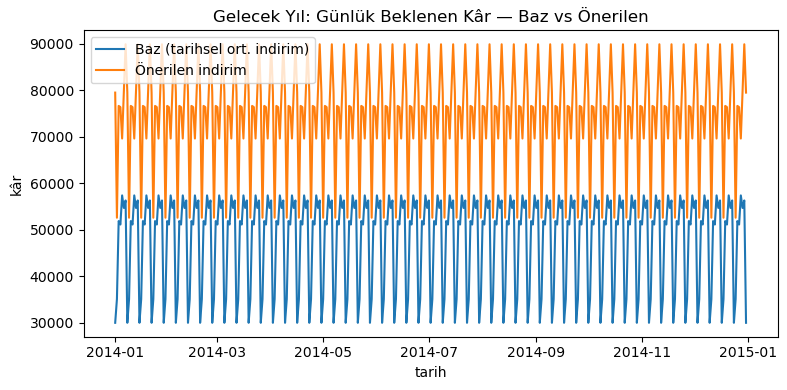

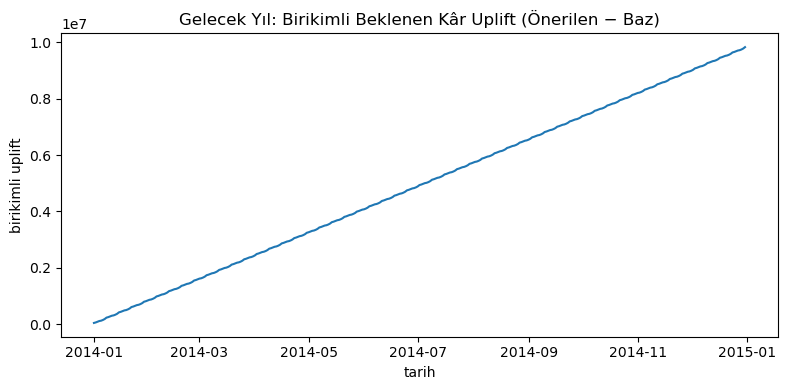

In [4]:
# Baz senaryo: her product×day_name için tarihsel ortalama indirimi kullan
hist_avg_d = (data.groupby([PRODUCT_COL, DAYNAME_COL])[DISCOUNT_COL]
                 .mean().rename("hist_avg_discount"))
future_cmp = future.merge(hist_avg_d, on=[PRODUCT_COL, DAYNAME_COL], how="left")

# Önerilen indirim zaten 'recommended_discount' kolonu olarak oluşturulmuş olmalı (next-year plan hücrenizde)
if "recommended_discount" not in future_cmp.columns:
    raise ValueError("Önce next-year plan hücresini koşup 'recommended_discount' kolonunu üretin.")

def simulate_profit(df, disc_col):
    # her satır için birim tahmini (modelle) ve kâr
    X = df[[DAYNAME_COL, PRODUCT_COL, DISCOUNT_COL, LIST_PRICE_COL, UNIT_COST_COL]].copy()
    X[DISCOUNT_COL] = df[disc_col].astype(float).fillna(0.0)
    units = np.maximum(pipe.predict(X[FEATS]), 0.0)
    margin = np.maximum(df[LIST_PRICE_COL]*(1.0 - X[DISCOUNT_COL]) - df[UNIT_COST_COL], 0.0)
    return pd.Series(units*margin, index=df.index)

future_cmp = future_cmp.copy()
future_cmp["profit_recommended"] = simulate_profit(future_cmp, "recommended_discount")
future_cmp["profit_baseline"]    = simulate_profit(future_cmp, "hist_avg_discount")

# Zaman serisi grafikleri (günlük toplam)
daily = (future_cmp
         .groupby("date_formatted", as_index=False)
         .agg(opt_profit=("profit_recommended","sum"),
              base_profit=("profit_baseline","sum")))

daily["uplift"] = daily["opt_profit"] - daily["base_profit"]
daily["cum_uplift"] = daily["uplift"].cumsum()

plt.figure(figsize=(8,4))
plt.plot(daily["date_formatted"], daily["base_profit"], label="Baz (tarihsel ort. indirim)")
plt.plot(daily["date_formatted"], daily["opt_profit"],  label="Önerilen indirim")
plt.title("Gelecek Yıl: Günlük Beklenen Kâr — Baz vs Önerilen")
plt.xlabel("tarih"); plt.ylabel("kâr")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(daily["date_formatted"], daily["cum_uplift"])
plt.title("Gelecek Yıl: Birikimli Beklenen Kâr Uplift (Önerilen − Baz)")
plt.xlabel("tarih"); plt.ylabel("birikimli uplift")
plt.tight_layout(); plt.show()


In [12]:
# === Profit Forecast for 2015 — Tahmin Kodu ===
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

# ---------- CONFIG ----------
CSV_PATH        = "globalsales_profit_iqr_cleaned.csv"  # senin data dosyası
DATE_COL        = "date_formatted"
DAYNAME_COL     = "day_name"
PRODUCT_COL     = "product"
PRODUCT_BINARIES = [
    "product_paseo", "product_amarilla", "product_velo",
    "product_vtt", "product_carretera", "product_montana"
]

SALE_PRICE_COL  = "sale_price"
DISCOUNT_COL    = "discount_rate_pct"
COGS_COL        = "cogs"

CANDIDATE_UNITS   = ["unit_sold","units_sold","units","qty","quantity","order_qty","sold_units","ordered_units"]
CANDIDATE_REVENUE = ["sales","revenue","net_sales","gross_sales","amount"]

LIST_PRICE_COL = "list_price"
UNIT_COST_COL  = "unit_cost"
PROFIT_COL     = "profit"
UNITS_COL      = "_units"

# Growth vars
PRICE_GROWTH_PCT = 0.00
COST_GROWTH_PCT  = 0.00

INCLUDE_WEEKENDS = True

MIN_DISC, MAX_DISC = 0.00, 0.50
STEP_COARSE, STEP_FINE = 0.05, 0.01

# ---------- HELPERS ----------
def _to_num01(s):
    x = pd.to_numeric(s, errors="coerce")
    if x.isna().all():
        mapped = s.astype(str).str.strip().str.lower().map(
            {"1":1,"true":1,"yes":1,"y":1,"t":1,"0":0,"false":0,"no":0,"n":0,"f":0}
        )
        x = pd.to_numeric(mapped, errors="coerce")
    return (x.fillna(0) > 0.5).astype(int)

def derive_product(df):
    if PRODUCT_COL in df.columns:
        return df
    miss = [c for c in PRODUCT_BINARIES if c not in df.columns]
    if miss:
        raise ValueError(f"Missing product binary cols: {miss}")
    out = df.copy()
    for c in PRODUCT_BINARIES:
        out[c] = _to_num01(out[c])
    def pick(r):
        for p in PRODUCT_BINARIES:
            if r[p] == 1:
                return p
        return np.nan
    out[PRODUCT_COL] = out.apply(pick, axis=1)
    return out.dropna(subset=[PRODUCT_COL])

def find_units_or_derive(df):
    for cand in CANDIDATE_UNITS:
        if cand in df.columns:
            u = pd.to_numeric(df[cand], errors="coerce").fillna(0.0)
            print(f"[INFO] Units found: {cand}")
            return u.clip(lower=0.0)
    # else try revenue
    rev_col = next((c for c in CANDIDATE_REVENUE if c in df.columns), None)
    if rev_col and SALE_PRICE_COL in df.columns and DISCOUNT_COL in df.columns:
        revenue = pd.to_numeric(df[rev_col], errors="coerce").fillna(0.0)
        price   = pd.to_numeric(df[SALE_PRICE_COL], errors="coerce").fillna(0.0)
        disc    = pd.to_numeric(df[DISCOUNT_COL], errors="coerce").fillna(0.0).clip(MIN_DISC, MAX_DISC)
        denom   = (price * (1.0 - disc)).replace(0, np.nan)
        units   = (revenue / denom).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        print(f"[INFO] Units derived from revenue via: {rev_col}")
        return units.clip(lower=0.0)
    raise ValueError("Units column not found & cannot derive from revenue.")

def prepare_data_for_forecast(df):
    df = df.copy()
    # zorunlu sütunlar
    required = [DATE_COL, DAYNAME_COL, SALE_PRICE_COL, DISCOUNT_COL, COGS_COL]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    df = derive_product(df)
    df[LIST_PRICE_COL] = pd.to_numeric(df[SALE_PRICE_COL], errors="coerce")
    units = find_units_or_derive(df)
    num = pd.to_numeric(df[COGS_COL], errors="coerce")
    den = units.replace(0, np.nan)
    df[UNIT_COST_COL] = (num / den).replace([np.inf, -np.inf], np.nan)
    med_cost = df[UNIT_COST_COL].median(skipna=True)
    df[UNIT_COST_COL] = df[UNIT_COST_COL].fillna(0.0 if not np.isfinite(med_cost) else med_cost)
    df[DISCOUNT_COL] = pd.to_numeric(df[DISCOUNT_COL], errors="coerce").clip(MIN_DISC, MAX_DISC).fillna(0.0)
    if PROFIT_COL not in df.columns:
        margin = df[LIST_PRICE_COL] * (1 - df[DISCOUNT_COL]) - df[UNIT_COST_COL]
        df[PROFIT_COL] = units * np.maximum(margin, 0.0)
    df[UNITS_COL] = units
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df

def build_model(df):
    cat = [DAYNAME_COL, PRODUCT_COL]
    num = [DISCOUNT_COL, LIST_PRICE_COL, UNIT_COST_COL]
    pre = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), cat),
                             ("num", "passthrough", num)])
    model = GradientBoostingRegressor(n_estimators=600, learning_rate=0.03, max_depth=3, random_state=42)
    pipe = Pipeline([("pre", pre), ("model", model)])
    return pipe, cat + num

def optimize_for_row(pipe, feature_cols, row, price, cost):
    best_profit, best_disc, best_units = -1e18, 0.0, 0.0
    for d in discount_grid():
        Xd = row[feature_cols].copy()
        Xd = Xd.copy()
        Xd[DISCOUNT_COL] = d
        u = float(pipe.predict(Xd)[0]); u = max(u,0.0)
        prof = expected_profit(u, price, cost, d)
        if prof > best_profit:
            best_profit, best_disc, best_units = prof, d, u
    return best_disc, best_units, best_profit

# ---------- EXECUTION ----------

raw = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL], low_memory=False)
historical = prepare_data_for_forecast(raw)

# filtre: sadece Aralık 2014'e kadar al (zaten öyle ama kontrol için)
historical = historical[historical[DATE_COL] <= pd.Timestamp(2014,12,31)]

pipe, FEATS = build_model(historical)
pipe.fit(historical[FEATS], historical[UNITS_COL])

# 2015 takvimi oluştur
start = pd.Timestamp(2015,1,1); end = pd.Timestamp(2015,12,31)
all_days = pd.date_range(start, end, freq="D")
if not INCLUDE_WEEKENDS:
    all_days = all_days[all_days.weekday < 5]
future = pd.DataFrame({DATE_COL: all_days})
future[DAYNAME_COL] = future[DATE_COL].dt.day_name()
products = np.sort(historical[PRODUCT_COL].unique())
future = future.merge(pd.DataFrame({PRODUCT_COL: products}), how="cross")

# fiyat/maliyet varsayımları
prod_price = historical.groupby(PRODUCT_COL)[LIST_PRICE_COL].median().rename("hist_price_med")
prod_cost  = historical.groupby(PRODUCT_COL)[UNIT_COST_COL].median().rename("hist_cost_med")
future = future.merge(prod_price, on=PRODUCT_COL, how="left").merge(prod_cost, on=PRODUCT_COL, how="left")
future[LIST_PRICE_COL] = future["hist_price_med"] * (1 + PRICE_GROWTH_PCT)
future[UNIT_COST_COL]  = future["hist_cost_med"] * (1 + COST_GROWTH_PCT)
future[DISCOUNT_COL]    = 0.0

# optimum indirim + tahmin
opt_d, opt_u, opt_p = [], [], []
for _, row in future.iterrows():
    price = float(row[LIST_PRICE_COL]); cost = float(row[UNIT_COST_COL])
    rd, ru, rp = optimize_for_row(pipe, FEATS, row.to_frame().T, price, cost)
    opt_d.append(rd); opt_u.append(ru); opt_p.append(rp)
future["recommended_discount"] = opt_d
future["pred_units"] = opt_u
future["expected_profit"] = opt_p

# toplam kâr tahmini
total_profit_2015 = future["expected_profit"].sum()
print(f"Expected total profit for 2015 with optimized discounts: {total_profit_2015:,.2f}")


[INFO] Units found: units_sold
Expected total profit for 2015 with optimized discounts: 24,596,171.65


In [5]:
import sklearn
print(sklearn.__version__)


1.7.2


In [6]:
# ==== PDP & ICE: discount_rate_pct → predicted units ====
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

X_hist = historical[FEATS]

# PDP (average effect)
fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    pipe,
    X_hist,
    features=[DISCOUNT_COL],   # use feature NAME (pipeline-safe)
    kind="average",
    grid_resolution=60
)
ax.set_title("PDP: discount_rate_pct \u2192 predicted units")
ax.set_xlabel(DISCOUNT_COL); ax.set_ylabel("Predicted units")
fig.tight_layout()
fig.savefig("pdp_discount_units.png", dpi=200, bbox_inches="tight")
plt.show()

# ICE (individual curves; subsample for clarity)
import numpy as np
rng = np.random.RandomState(42)
take = min(500, len(X_hist))
X_ice = X_hist.iloc[rng.choice(len(X_hist), size=take, replace=False)]

fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    pipe,
    X_ice,
    features=[DISCOUNT_COL],
    kind="individual",
    grid_resolution=60
)
ax.set_title("ICE: discount_rate_pct \u2192 predicted units")
ax.set_xlabel(DISCOUNT_COL); ax.set_ylabel("Predicted units")
fig.tight_layout()
fig.savefig("ice_discount_units.png", dpi=200, bbox_inches="tight")
plt.show()


NameError: name 'historical' is not defined

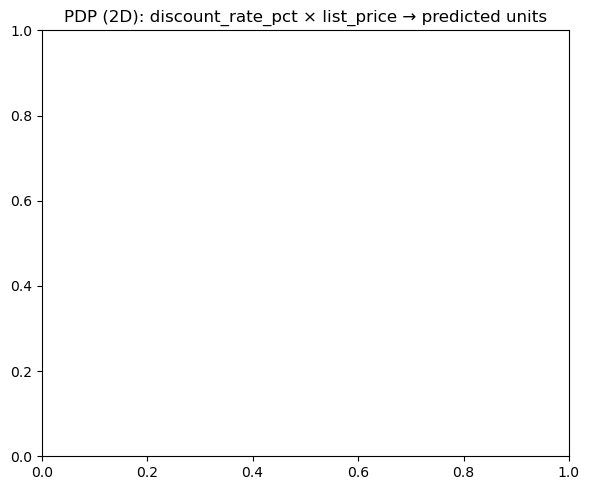

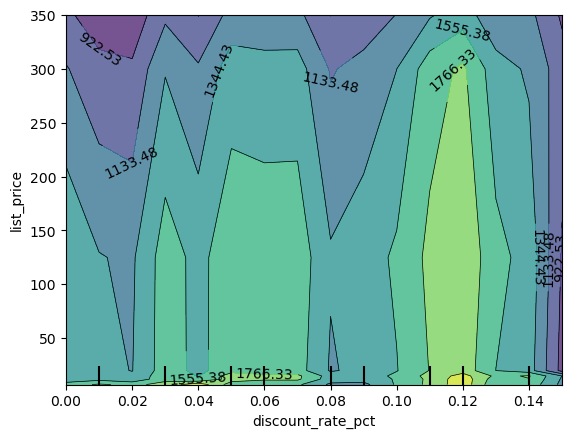

In [33]:
# ==== 2D PDP: (discount_rate_pct, list_price) ====
fig, ax = plt.subplots(figsize=(6, 5))
PartialDependenceDisplay.from_estimator(
    pipe,
    X_hist,
    features=[(DISCOUNT_COL, LIST_PRICE_COL)],
    kind="average",
    grid_resolution=40
)
ax.set_title("PDP (2D): discount_rate_pct \u00D7 list_price \u2192 predicted units")
fig.tight_layout()
fig.savefig("pdp_2d_discount_listprice.png", dpi=200, bbox_inches="tight")
plt.show()


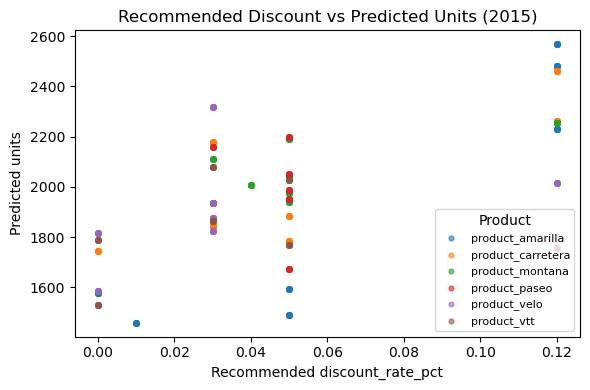

In [34]:
# ==== Scatter: recommended_discount vs pred_units ====
fig, ax = plt.subplots(figsize=(6, 4))
for p in sorted(future[PRODUCT_COL].unique()):
    sub = future[future[PRODUCT_COL] == p]
    ax.scatter(sub["recommended_discount"], sub["pred_units"], s=12, alpha=0.6, label=p)
ax.set_xlabel("Recommended discount_rate_pct")
ax.set_ylabel("Predicted units")
ax.set_title("Recommended Discount vs Predicted Units (2015)")
ax.legend(title="Product", fontsize=8, markerscale=1)
fig.tight_layout()
fig.savefig("scatter_discount_vs_units.png", dpi=200, bbox_inches="tight")
plt.show()


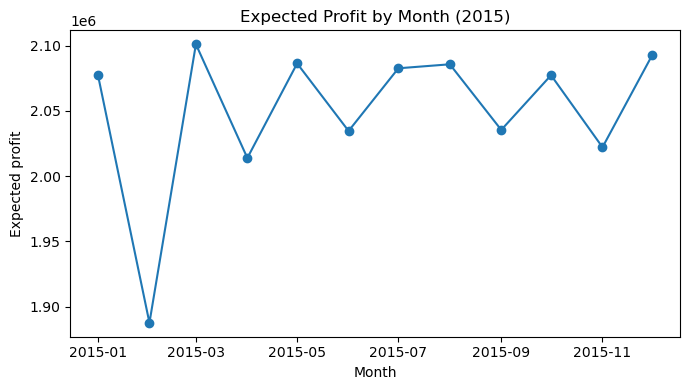

In [50]:
# ==== Monthly expected profit ====
m = future.copy()
m["month"] = m[DATE_COL].values.astype("datetime64[M]")
monthly = m.groupby("month")["expected_profit"].sum()

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(monthly.index, monthly.values, marker="o")
ax.set_title("Expected Profit by Month (2015)")
ax.set_xlabel("Month"); ax.set_ylabel("Expected profit")
fig.tight_layout()
fig.savefig("monthly_expected_profit.png", dpi=200, bbox_inches="tight")
plt.show()


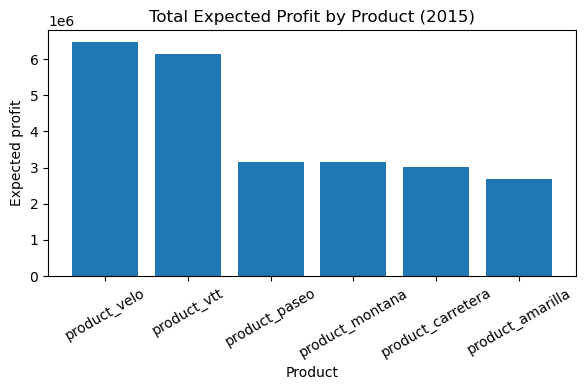

In [27]:
# ==== 2015 total expected profit by product ====
prod_profit = future.groupby(PRODUCT_COL)["expected_profit"].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(prod_profit.index.astype(str), prod_profit.values)
ax.set_title("Total Expected Profit by Product (2015)")
ax.set_xlabel("Product"); ax.set_ylabel("Expected profit")
ax.tick_params(axis="x", rotation=30)
fig.tight_layout()
fig.savefig("product_expected_profit.png", dpi=200, bbox_inches="tight")
plt.show()


C:\Users\hk7\AppData\Local\Temp\ipykernel_20476\1473897947.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = hm.pivot_table(index="weekday", columns=PRODUCT_COL, values="recommended_discount", aggfunc="mean")


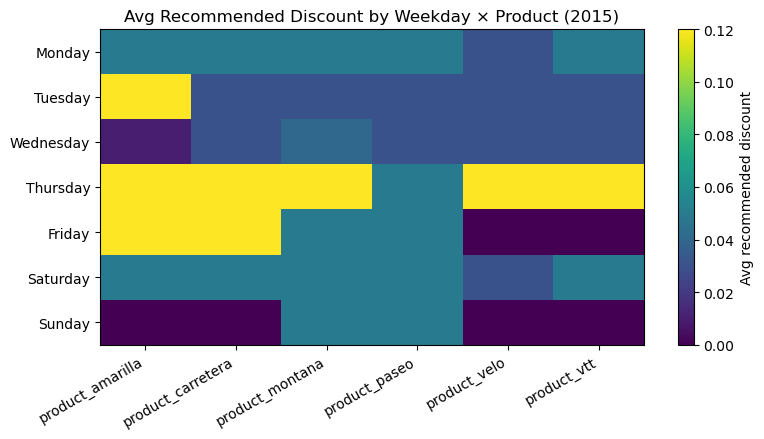

In [28]:
# ==== Heatmap: weekday × product (avg recommended discount) ====
wk_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
hm = future.copy()
hm["weekday"] = pd.Categorical(hm[DAYNAME_COL], categories=wk_order, ordered=True)
pivot = hm.pivot_table(index="weekday", columns=PRODUCT_COL, values="recommended_discount", aggfunc="mean")

fig, ax = plt.subplots(figsize=(8, 4.5))
# simple imshow for a seaborn-free heatmap
im = ax.imshow(pivot.values, aspect="auto")
ax.set_xticks(range(len(pivot.columns))); ax.set_xticklabels(pivot.columns, rotation=30, ha="right")
ax.set_yticks(range(len(pivot.index)));   ax.set_yticklabels(pivot.index)
ax.set_title("Avg Recommended Discount by Weekday × Product (2015)")
fig.colorbar(im, ax=ax, label="Avg recommended discount")
fig.tight_layout()
fig.savefig("heatmap_discount_weekday_product.png", dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
# ==== Beautiful PDP / Centered ICE (no KMeans), plus 2D PDP ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

X_hist = historical[FEATS].copy()

# --- helper: grid within data support
def _grid_from_data(x, n=60, trim=(0.01, 0.99)):
    lo, hi = np.nanquantile(x, [trim[0], trim[1]])
    return np.linspace(lo, hi, n)

# --- helper: compute ICE by brute force prediction sweeps
def compute_ice(estimator, X, feat_name, grid):
    X = X.copy()
    ice = np.empty((len(X), len(grid)), dtype=float)
    base = X[feat_name].values
    for j, g in enumerate(grid):
        X[feat_name] = g
        ice[:, j] = estimator.predict(X)
    X[feat_name] = base
    return ice

# 1) PDP + Centered ICE for discount_rate_pct
grid = _grid_from_data(X_hist[DISCOUNT_COL], n=60, trim=(0.01, 0.99))
ice  = compute_ice(pipe, X_hist, DISCOUNT_COL, grid)

# center ICE at the median grid value (reveals shape differences cleanly)
ref_idx   = np.argmin(np.abs(grid - np.median(grid)))
centered  = ice - ice[:, [ref_idx]]
pdp_line  = centered.mean(axis=0)

fig, ax = plt.subplots(figsize=(7, 4.5))
for row in centered:
    ax.plot(grid, row, lw=0.6, alpha=0.12)
ax.plot(grid, pdp_line, lw=3.0)                  # PDP (centered)
ax.axhline(0, ls="--", lw=0.8, color="0.4")

# add light rug/quantiles so you see data support
qs = np.quantile(X_hist[DISCOUNT_COL].dropna(), np.linspace(0,1,21))
for v in qs: ax.axvline(v, color="0.9", lw=0.6, alpha=0.8)

ax.set_title("Centered ICE + PDP: discount_rate_pct → predicted units")
ax.set_xlabel("discount_rate_pct")
ax.set_ylabel("Δ Predicted units (centered)")
fig.tight_layout(); fig.savefig("pdp_ice_discount_better.png", dpi=220, bbox_inches="tight")
plt.show()

# 2) 2-D PDP: (discount_rate_pct, list_price) → predicted units
# Use indices for broad sklearn compatibility on 2D tuples
f_disc = FEATS.index(DISCOUNT_COL)
f_list = FEATS.index(LIST_PRICE_COL)

fig, ax = plt.subplots(figsize=(7, 5.2))
PartialDependenceDisplay.from_estimator(
    pipe,
    X_hist,
    features=[(f_disc, f_list)],     # tuple of indices (recommended for 2D PDPs)
    kind="average",
    grid_resolution=50,
    ax=ax,
)
# overlay observed points to show where you actually have data
ax.scatter(X_hist[DISCOUNT_COL], X_hist[LIST_PRICE_COL], s=6, alpha=0.15)

ax.set_title("2D PDP: discount_rate_pct × list_price → predicted units")
ax.set_xlabel("discount_rate_pct"); ax.set_ylabel("list_price")
fig.tight_layout(); fig.savefig("pdp_2d_discount_listprice_better.png", dpi=220, bbox_inches="tight")
plt.show()


In [7]:
# ==== Batch charts for ALL products × weekdays (2015 plan) ====
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Fallbacks (use your existing ones if defined) ----------
try:
    discount_grid
except NameError:
    MIN_DISC = globals().get("MIN_DISC", 0.00)
    MAX_DISC = globals().get("MAX_DISC", 0.50)
    STEP_COARSE = globals().get("STEP_COARSE", 0.05)
    def discount_grid(step=None):
        step = STEP_COARSE if step is None else step
        n = int(round((MAX_DISC - MIN_DISC) / step)) + 1
        return np.linspace(MIN_DISC, MAX_DISC, n)

try:
    expected_profit
except NameError:
    def expected_profit(units, price, cost, disc):
        return float(units) * max(price * (1.0 - float(disc)) - float(cost), 0.0)

# ---------- Config ----------
OUT_DIR = "plots_2015_segments"
os.makedirs(OUT_DIR, exist_ok=True)
DGRID = discount_grid()           # use STEP_FINE in your config if you want a smoother sweep
WEEK_ORDER = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# ---------- Helpers ----------
def safe_name(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", str(s))

def make_xgrid_for_segment(prod, wday, price, cost, feats, dgrid):
    """Create a DataFrame with len(dgrid) rows for a single (product, weekday) segment."""
    base = pd.DataFrame({
        DAYNAME_COL:    [wday],
        PRODUCT_COL:    [prod],
        DISCOUNT_COL:   [0.0],
        LIST_PRICE_COL: [price],
        UNIT_COST_COL:  [cost],
    })
    X = pd.concat([base] * len(dgrid), ignore_index=True)
    X.loc[:, DISCOUNT_COL] = dgrid
    return X[feats].copy(), dgrid

def plot_and_save_segment(prod, wday, dgrid, units_curve, profit_curve, hist_avg_d=None):
    best_idx = int(np.argmax(profit_curve))
    best_d   = float(dgrid[best_idx])

    fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Profit
    ax = axes[0]
    ax.plot(dgrid, profit_curve, lw=2.2, label="Expected profit (2015)")
    ax.axvline(best_d, ls="--", lw=1.5, label=f"Recommended ≈ {best_d:.2f}")
    if hist_avg_d is not None and np.isfinite(hist_avg_d):
        ax.axvline(float(hist_avg_d), ls=":", lw=1.5, label=f"Historical avg ≈ {hist_avg_d:.2f}")
    ax.set_title(f"Profit vs Discount — {prod}, {wday}")
    ax.set_ylabel("expected profit")
    ax.legend()

    # Units
    ax = axes[1]
    ax.plot(dgrid, units_curve, lw=2.2)
    ax.set_title(f"Predicted Units vs Discount — {prod}, {wday}")
    ax.set_xlabel("discount_rate_pct")
    ax.set_ylabel("predicted units")

    fig.tight_layout()
    outfile = os.path.join(OUT_DIR, f"{safe_name(prod)}__{safe_name(wday)}.png")
    fig.savefig(outfile, dpi=220, bbox_inches="tight")  # guaranteed file even on non-GUI backends
    plt.close(fig)
    return outfile, best_idx

# ---------- Main loop ----------
assert 'pipe' in globals() and 'FEATS' in globals(), "Model pipeline (pipe) or FEATS missing."
assert 'historical' in globals() and 'future' in globals(), "historical/future DataFrames missing."

products = list(np.sort(historical[PRODUCT_COL].dropna().unique()))
# honor weekday order; fall back to values present
weekdays = [d for d in WEEK_ORDER if d in future[DAYNAME_COL].unique().tolist()]

summary_rows = []

for prod in products:
    for wday in weekdays:
        seg_hist = historical[(historical[PRODUCT_COL] == prod) & (historical[DAYNAME_COL] == wday)]
        seg_fut  = future[(future[PRODUCT_COL] == prod) & (future[DAYNAME_COL] == wday)]
        if seg_fut.empty:
            continue  # no calendar rows for this combo in 2015 plan

        price = float(seg_fut[LIST_PRICE_COL].median())
        cost  = float(seg_fut[UNIT_COST_COL].median())
        if not np.isfinite(price) or not np.isfinite(cost):
            continue

        # build grid rows once and predict in batch
        Xgrid, dgrid = make_xgrid_for_segment(prod, wday, price, cost, FEATS, DGRID)
        yhat = pipe.predict(Xgrid)
        yhat = np.maximum(yhat, 0.0)  # guard against tiny negatives

        units_curve  = yhat
        profit_curve = np.array([expected_profit(u, price, cost, d) for u, d in zip(units_curve, dgrid)])

        hist_avg_d = float(seg_hist[DISCOUNT_COL].mean()) if len(seg_hist) else np.nan
        outfile, best_idx = plot_and_save_segment(prod, wday, dgrid, units_curve, profit_curve, hist_avg_d)

        summary_rows.append({
            "product": prod,
            "weekday": wday,
            "price_med_2015": price,
            "cost_med_2015": cost,
            "best_discount": float(dgrid[best_idx]),
            "pred_units_at_best": float(units_curve[best_idx]),
            "expected_profit_at_best": float(profit_curve[best_idx]),
            "hist_avg_discount": (None if (not len(seg_hist) or np.isnan(hist_avg_d)) else float(hist_avg_d)),
            "chart_file": outfile,
        })

# Save a tidy CSV summary for all segments
summary_df = pd.DataFrame(summary_rows)
summary_path = os.path.join(OUT_DIR, "segment_2015_summary.csv")
summary_df.to_csv(summary_path, index=False)

print(f"[DONE] Saved {len(summary_df)} segment charts to: {OUT_DIR}")
print(f"[Summary] CSV: {summary_path}")
print(summary_df.head(10))


AssertionError: historical/future DataFrames missing.

In [ ]:
# ==== 2014 vs 2015 Profit: Monthly + Cumulative Line Charts ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes these already exist from your earlier cells:
# historical (DataFrame), future (DataFrame), DATE_COL, PROFIT_COL
# future has expected_profit for 2015

def monthly_series(df, date_col, value_col, year):
    """Return a 12-point monthly sum Series for the given year (Jan..Dec)."""
    sub = df[df[date_col].dt.year == year].copy()
    if sub.empty:
        # create an all-zero series if nothing found (keeps charts stable)
        idx = pd.period_range(f"{year}-01", f"{year}-12", freq="M").to_timestamp()
        return pd.Series(0.0, index=idx)
    s = sub.groupby(sub[date_col].dt.to_period("M"))[value_col].sum().sort_index().to_timestamp()
    idx = pd.period_range(f"{year}-01", f"{year}-12", freq="M").to_timestamp()
    return s.reindex(idx, fill_value=0.0)

m2014 = monthly_series(historical, DATE_COL, PROFIT_COL, 2014)
m2015 = monthly_series(future,     DATE_COL, "expected_profit", 2015)

# Optional: Year-over-year (YoY) delta per month
yoy_abs  = m2015 - m2014
yoy_pct  = (m2015 - m2014) / m2014.replace(0, np.nan) * 100

# 1) Monthly profit line chart
fig, ax = plt.subplots(figsize=(8, 4.6))
ax.plot(m2014.index, m2014.values, marker="o", label="2014 profit (actual)")
ax.plot(m2015.index, m2015.values, marker="o", label="2015 profit (expected)")
ax.set_title("Monthly Profit: 2014 vs 2015")
ax.set_xlabel("Month")
ax.set_ylabel("Profit")
ax.legend()
ax.grid(True, linewidth=0.4, alpha=0.5)
fig.tight_layout()
fig.savefig("profit_monthly_2014_vs_2015.png", dpi=220, bbox_inches="tight")
plt.show()

# 2) Cumulative profit line chart
fig, ax = plt.subplots(figsize=(8, 4.6))
ax.plot(m2014.index, m2014.cumsum().values, marker="o", label="2014 cumulative")
ax.plot(m2015.index, m2015.cumsum().values, marker="o", label="2015 cumulative (expected)")
ax.set_title("Cumulative Profit: 2014 vs 2015")
ax.set_xlabel("Month")
ax.set_ylabel("Cumulative profit")
ax.legend()
ax.grid(True, linewidth=0.4, alpha=0.5)
fig.tight_layout()
fig.savefig("profit_cumulative_2014_vs_2015.png", dpi=220, bbox_inches="tight")
plt.show()

# Small textual summary
print(f"2014 total profit (actual):   {m2014.sum():,.2f}")
print(f"2015 total profit (expected): {m2015.sum():,.2f}")
print(f"Δ vs 2014 (abs):              {(m2015.sum()-m2014.sum()):,.2f}")
if np.isfinite(yoy_pct).any():
    print("Median YoY % across months:   {:.1f}%".format(np.nanmedian(yoy_pct)))


In [9]:
# ===== Elasticity-aware optimization on top of your fitted GBR =====
import numpy as np
import pandas as pd

def _eff_price(list_price, disc):
    return float(list_price) * (1.0 - float(disc))

def _local_elasticity(pipe, Xrow_df, FEATS, delta_disc=0.01):
    """
    Central-difference elasticity around current discount.
    Returns (epsilon_local, P0, Q0) where epsilon_local is negative (law of demand).
    """
    row = Xrow_df.copy()
    P0 = _eff_price(row[LIST_PRICE_COL].iat[0], row[DISCOUNT_COL].iat[0])

    # move discount up/down a tiny step to change effective price
    d0 = float(row[DISCOUNT_COL].iat[0])
    d_up = max(MIN_DISC, d0 - delta_disc)   # higher price
    d_dn = min(MAX_DISC, d0 + delta_disc)   # lower price

    X_up = row.copy(); X_up[DISCOUNT_COL] = d_up
    X_dn = row.copy(); X_dn[DISCOUNT_COL] = d_dn

    Q0  = float(pipe.predict(row[FEATS])[0])
    Qup = float(pipe.predict(X_up[FEATS])[0])
    Qdn = float(pipe.predict(X_dn[FEATS])[0])

    Pup = _eff_price(row[LIST_PRICE_COL].iat[0], d_up)
    Pdn = _eff_price(row[LIST_PRICE_COL].iat[0], d_dn)

    # numerical derivative dQ/dP (central difference)
    dQdP = (Qup - Qdn) / (Pup - Pdn + 1e-12)
    eps  = dQdP * (P0 / max(Q0, 1e-12))    # elasticity (will be negative)
    return eps, P0, Q0

def _lerner_price(cost, eps):
    """Compute P* from Lerner rule using elasticity magnitude |eps|."""
    E = abs(float(eps))
    if not np.isfinite(E) or E <= 1.0:
        return cost  # if inelastic or undefined, don't mark up above cost
    return (E / (E - 1.0)) * float(cost)

# run elasticity-aware optimization row-by-row
rec_d, rec_u, rec_p, rec_eps = [], [], [], []
for _, row in future.iterrows():
    rowdf = row.to_frame().T.copy()
    # baseline discount 0 already set by your code; OK for local epsilon
    eps, P0, Q0 = _local_elasticity(pipe, rowdf, FEATS, delta_disc=0.01)
    cost = float(row[UNIT_COST_COL]); listp = float(row[LIST_PRICE_COL])

    Pstar = _lerner_price(cost, eps)
    dstar = 1.0 - Pstar / max(listp, 1e-12)
    dstar = float(np.clip(dstar, MIN_DISC, MAX_DISC))

    Xstar = rowdf.copy(); Xstar[DISCOUNT_COL] = dstar
    ustar = float(max(pipe.predict(Xstar[FEATS])[0], 0.0))
    profit = (_eff_price(listp, dstar) - cost) * ustar

    rec_eps.append(eps)
    rec_d.append(dstar)
    rec_u.append(ustar)
    rec_p.append(profit)

future["elasticity_local"] = rec_eps
future["recommended_discount_elastic"] = rec_d
future["pred_units_elastic"] = rec_u
future["expected_profit_elastic"] = rec_p

print(
    "Elasticity-aware 2015 expected total profit:",
    f"{future['expected_profit_elastic'].sum():,.2f}"
)


Elasticity-aware 2015 expected total profit: 5,298,546.98


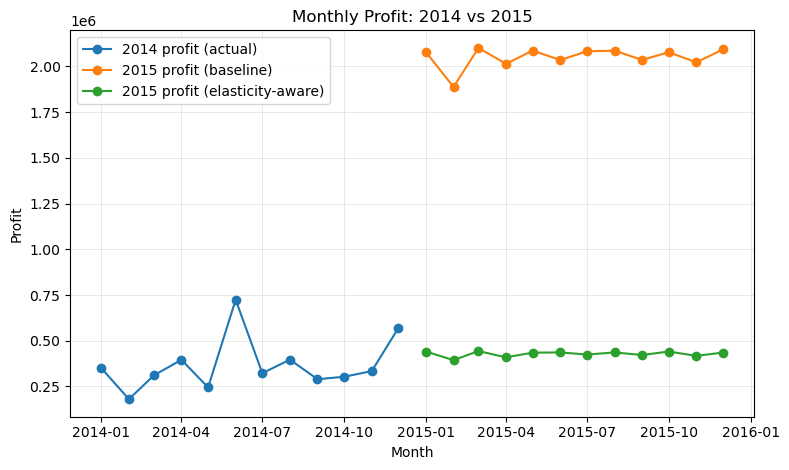

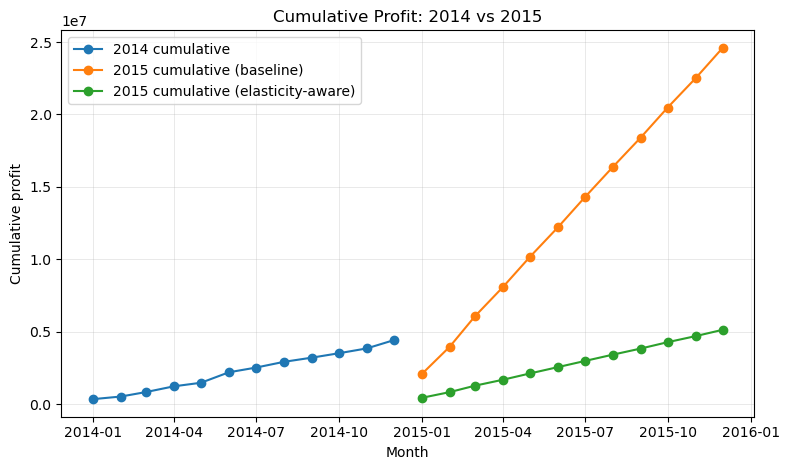

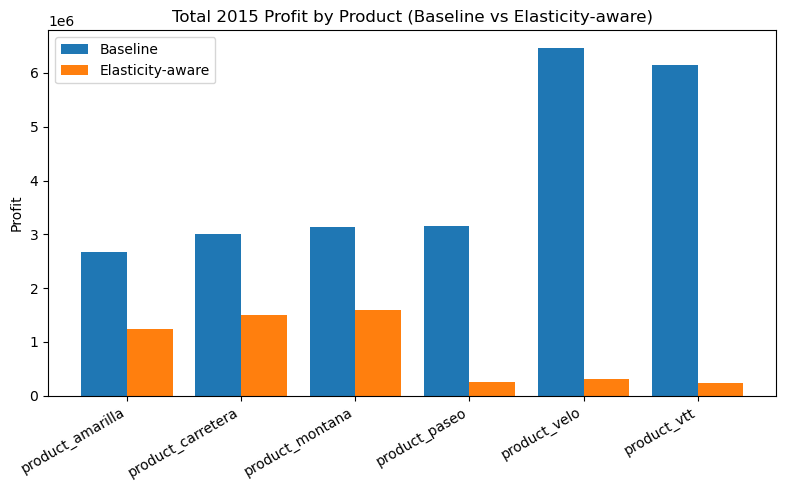

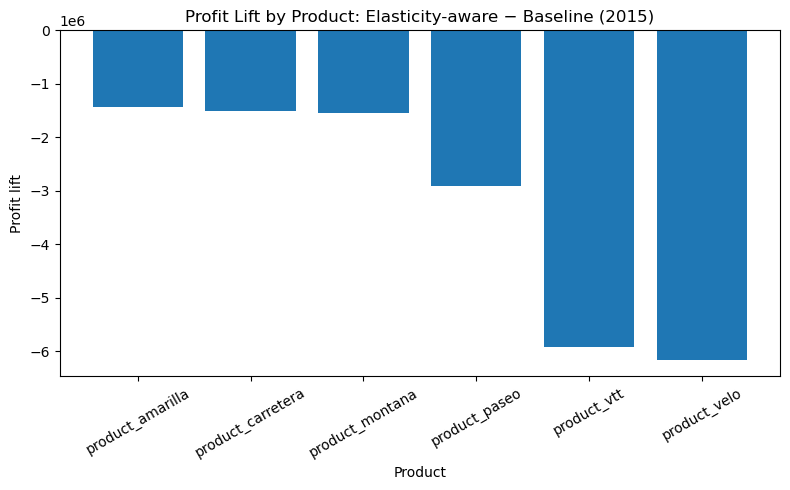

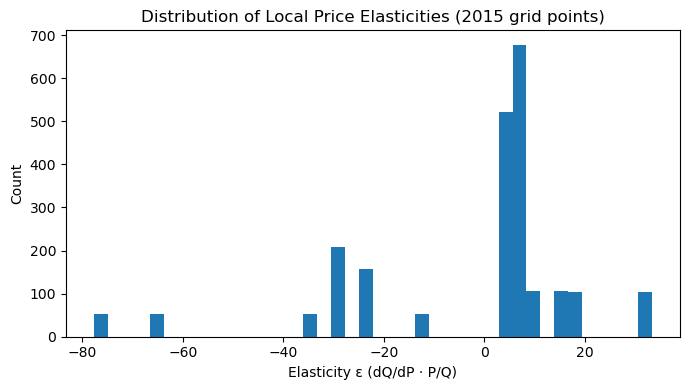

2014 total profit (actual):       4,422,148.78
2015 total profit (baseline):     24,596,171.65
2015 total profit (elasticity):   5,136,424.85  |  Δ vs baseline: -19,459,746.80


In [54]:
# ==== Visualizing 2014 vs 2015 (baseline & elasticity-aware) ====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "plots_profit_views"
os.makedirs(OUT_DIR, exist_ok=True)

def monthly_series(df, date_col, value_col, year):
    sub = df[df[date_col].dt.year == year].copy()
    idx = pd.period_range(f"{year}-01", f"{year}-12", freq="M").to_timestamp()
    if sub.empty:
        return pd.Series(0.0, index=idx)
    s = sub.groupby(sub[date_col].dt.to_period("M"))[value_col].sum().sort_index().to_timestamp()
    return s.reindex(idx, fill_value=0.0)

# --- build monthly series
m2014 = monthly_series(historical, DATE_COL, PROFIT_COL, 2014)
m2015_base = monthly_series(future, DATE_COL, "expected_profit", 2015)
m2015_elas = monthly_series(future, DATE_COL, "expected_profit_elastic", 2015) if "expected_profit_elastic" in future.columns else None
m2015_iso  = monthly_series(future, DATE_COL, "profit_isoelastic", 2015) if "profit_isoelastic" in future.columns else None

# 1) Monthly profit line chart
fig, ax = plt.subplots(figsize=(8, 4.8))
ax.plot(m2014.index, m2014.values, marker="o", label="2014 profit (actual)")
ax.plot(m2015_base.index, m2015_base.values, marker="o", label="2015 profit (baseline)")
if m2015_elas is not None:
    ax.plot(m2015_elas.index, m2015_elas.values, marker="o", label="2015 profit (elasticity-aware)")
if m2015_iso is not None:
    ax.plot(m2015_iso.index, m2015_iso.values, marker="o", label="2015 profit (isoelastic)")
ax.set_title("Monthly Profit: 2014 vs 2015")
ax.set_xlabel("Month"); ax.set_ylabel("Profit"); ax.legend(); ax.grid(True, linewidth=0.4, alpha=0.5)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "profit_monthly_lines.png"), dpi=220, bbox_inches="tight")
plt.show()

# 2) Cumulative profit
fig, ax = plt.subplots(figsize=(8, 4.8))
ax.plot(m2014.index, m2014.cumsum().values, marker="o", label="2014 cumulative")
ax.plot(m2015_base.index, m2015_base.cumsum().values, marker="o", label="2015 cumulative (baseline)")
if m2015_elas is not None:
    ax.plot(m2015_elas.index, m2015_elas.cumsum().values, marker="o", label="2015 cumulative (elasticity-aware)")
if m2015_iso is not None:
    ax.plot(m2015_iso.index, m2015_iso.cumsum().values, marker="o", label="2015 cumulative (isoelastic)")
ax.set_title("Cumulative Profit: 2014 vs 2015")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative profit"); ax.legend(); ax.grid(True, linewidth=0.4, alpha=0.5)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "profit_cumulative_lines.png"), dpi=220, bbox_inches="tight")
plt.show()

# 3) Per-product totals and lift (2015)
prod_base = future.groupby(PRODUCT_COL)["expected_profit"].sum().sort_values(ascending=False)
prod_elas = future.groupby(PRODUCT_COL)["expected_profit_elastic"].sum() if "expected_profit_elastic" in future.columns else None

# 3a) Bars: baseline vs elasticity-aware by product
if prod_elas is not None:
    # align indexes
    all_prods = prod_base.index.union(prod_elas.index)
    b = prod_base.reindex(all_prods, fill_value=0.0)
    e = prod_elas.reindex(all_prods, fill_value=0.0)

    fig, ax = plt.subplots(figsize=(max(8, len(all_prods)*0.6), 5))
    x = np.arange(len(all_prods))
    width = 0.4
    ax.bar(x - width/2, b.values, width, label="Baseline")
    ax.bar(x + width/2, e.values, width, label="Elasticity-aware")
    ax.set_xticks(x); ax.set_xticklabels(all_prods, rotation=30, ha="right")
    ax.set_title("Total 2015 Profit by Product (Baseline vs Elasticity-aware)")
    ax.set_ylabel("Profit"); ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, "profit_by_product_baseline_vs_elastic.png"), dpi=220, bbox_inches="tight")
    plt.show()

    # 3b) Lift bars
    lift = (e - b).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(max(8, len(lift)*0.6), 5))
    ax.bar(lift.index.astype(str), lift.values)
    ax.set_title("Profit Lift by Product: Elasticity-aware − Baseline (2015)")
    ax.set_xlabel("Product"); ax.set_ylabel("Profit lift")
    ax.tick_params(axis="x", rotation=30)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, "profit_lift_by_product.png"), dpi=220, bbox_inches="tight")
    plt.show()

# 4) (Optional) Elasticity distribution — sanity check
if "elasticity_local" in future.columns:
    fig, ax = plt.subplots(figsize=(7, 4))
    vals = future["elasticity_local"].replace([np.inf, -np.inf], np.nan).dropna()
    ax.hist(vals.values, bins=40)
    ax.set_title("Distribution of Local Price Elasticities (2015 grid points)")
    ax.set_xlabel("Elasticity ε (dQ/dP · P/Q)"); ax.set_ylabel("Count")
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, "elasticity_histogram.png"), dpi=220, bbox_inches="tight")
    plt.show()

# Summary lines
tot14 = m2014.sum()
tot15_base = m2015_base.sum()
tot15_elas = float("nan") if m2015_elas is None else m2015_elas.sum()
tot15_iso  = float("nan") if m2015_iso is None else m2015_iso.sum()
print(f"2014 total profit (actual):       {tot14:,.2f}")
print(f"2015 total profit (baseline):     {tot15_base:,.2f}")
if np.isfinite(tot15_elas):
    print(f"2015 total profit (elasticity):   {tot15_elas:,.2f}  |  Δ vs baseline: {(tot15_elas - tot15_base):,.2f}")
if np.isfinite(tot15_iso):
    print(f"2015 total profit (isoelastic):   {tot15_iso:,.2f}   |  Δ vs baseline: {(tot15_iso - tot15_base):,.2f}")


In [ ]:
# ==== 2014 actual vs 2015 (elasticity-aware) ONLY ====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes:
# - historical[DATE_COL, PROFIT_COL] for 2014 actuals
# - future[DATE_COL, "expected_profit_elastic"] for 2015 elasticity-aware
# - constants: DATE_COL, PROFIT_COL, PRODUCT_COL

OUT_DIR = "plots_profit_views_elastic_only"
os.makedirs(OUT_DIR, exist_ok=True)

# Helper: 12-point monthly series (Jan..Dec), fills missing months with 0
def monthly_series(df, date_col, value_col, year):
    sub = df[df[date_col].dt.year == year].copy()
    idx = pd.period_range(f"{year}-01", f"{year}-12", freq="M").to_timestamp()   # clean monthly index
    if sub.empty:
        return pd.Series(0.0, index=idx)
    s = (sub
         .groupby(sub[date_col].dt.to_period("M"))[value_col]  # group by month
         .sum().sort_index()
         .to_timestamp())                                      # PeriodIndex -> Timestamp for plotting
    return s.reindex(idx, fill_value=0.0)

# Build series
m2014 = monthly_series(historical, DATE_COL, PROFIT_COL, 2014)
if "expected_profit_elastic" not in future.columns:
    raise KeyError("future['expected_profit_elastic'] not found. Compute elasticity-aware profits first.")
m2015E = monthly_series(future, DATE_COL, "expected_profit_elastic", 2015)

# 1) Monthly line chart
fig, ax = plt.subplots(figsize=(8, 4.8))
ax.plot(m2014.index, m2014.values, marker="o", label="2014 profit (actual)")
ax.plot(m2015E.index, m2015E.values, marker="o", label="2015 profit (elasticity-aware)")
ax.set_title("Monthly Profit: 2014 vs 2015 (Elasticity-aware)")
ax.set_xlabel("Month"); ax.set_ylabel("Profit")
ax.legend(); ax.grid(True, linewidth=0.4, alpha=0.5)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "profit_monthly_2014_vs_2015_elastic.png"), dpi=220, bbox_inches="tight")
plt.show()

# 2) Cumulative line chart
fig, ax = plt.subplots(figsize=(8, 4.8))
ax.plot(m2014.index, m2014.cumsum().values, marker="o", label="2014 cumulative")
ax.plot(m2015E.index, m2015E.cumsum().values, marker="o", label="2015 cumulative (elasticity-aware)")
ax.set_title("Cumulative Profit: 2014 vs 2015 (Elasticity-aware)")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative profit")
ax.legend(); ax.grid(True, linewidth=0.4, alpha=0.5)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "profit_cumulative_2014_vs_2015_elastic.png"), dpi=220, bbox_inches="tight")
plt.show()

# 3) (Optional) Per-product totals: 2014 vs 2015 elasticity-aware
prod14 = (historical[historical[DATE_COL].dt.year == 2014]
          .groupby(PRODUCT_COL)[PROFIT_COL].sum()
          .sort_values(ascending=False))
prod15E = future.groupby(PRODUCT_COL)["expected_profit_elastic"].sum()

# align products present across years
all_prods = prod14.index.union(prod15E.index)
b14 = prod14.reindex(all_prods, fill_value=0.0)
e15 = prod15E.reindex(all_prods, fill_value=0.0)

fig, ax = plt.subplots(figsize=(max(8, len(all_prods)*0.6), 5))
x = np.arange(len(all_prods)); w = 0.42
ax.bar(x - w/2, b14.values, w, label="2014 actual")
ax.bar(x + w/2, e15.values, w, label="2015 elasticity-aware")
ax.set_xticks(x); ax.set_xticklabels(all_prods, rotation=30, ha="right")
ax.set_title("Total Profit by Product: 2014 vs 2015 (Elasticity-aware)")
ax.set_ylabel("Profit"); ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "profit_by_product_2014_vs_2015_elastic.png"), dpi=220, bbox_inches="tight")
plt.show()

# Summary lines
print(f"2014 total profit (actual):         {m2014.sum():,.2f}")
print(f"2015 total profit (elastic-aware):  {m2015E.sum():,.2f}")
print(f"Δ vs 2014 (abs):                    {(m2015E.sum()-m2014.sum()):,.2f}")


C:\Users\hk7\AppData\Local\Temp\ipykernel_20476\2486287956.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name).copy()


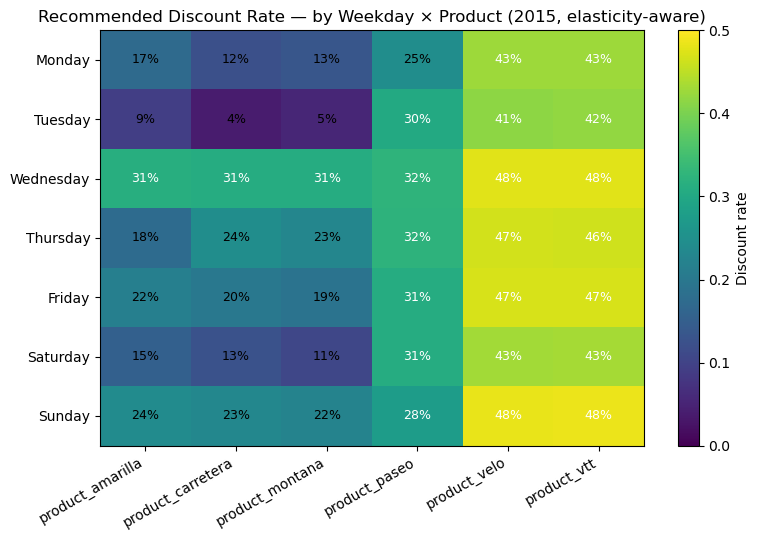

C:\Users\hk7\AppData\Local\Temp\ipykernel_20476\2486287956.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name).copy()


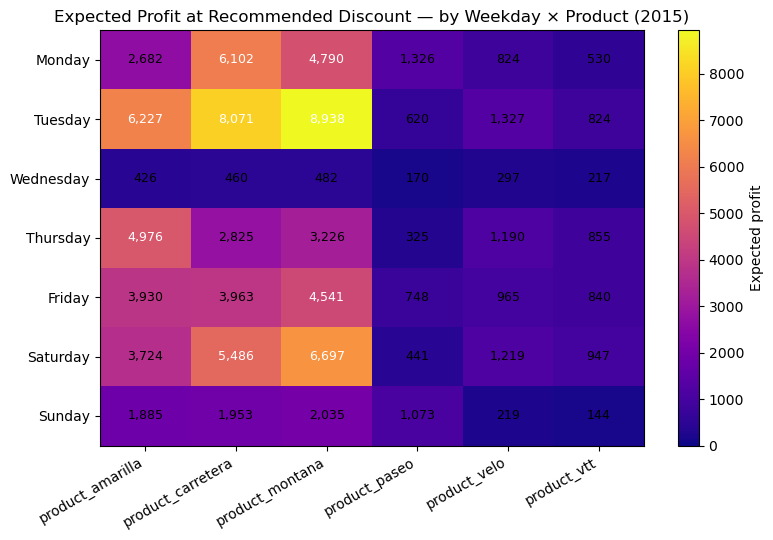

C:\Users\hk7\AppData\Local\Temp\ipykernel_20476\2486287956.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name).copy()


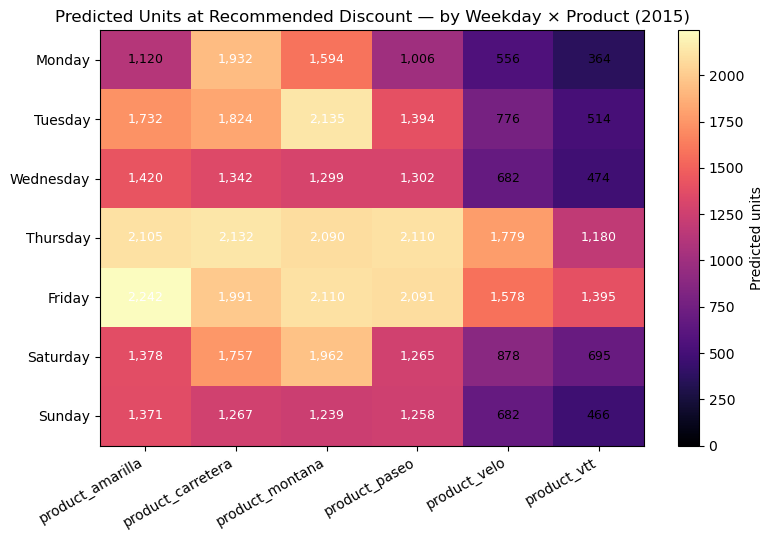

[SAVED]
CSV → plots_product_day_reco\product_weekday_recommendations.csv
PNGs → plots_product_day_reco


In [56]:
# ==== Product × Weekday heatmaps: Elasticity-aware discount recommendations ====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# -------- Config / columns (with safe fallbacks) --------
OUT_DIR = "plots_product_day_reco"
os.makedirs(OUT_DIR, exist_ok=True)

# prefer elasticity-aware columns; fall back to baseline if not present
DISC_COL  = "recommended_discount_elastic" if "recommended_discount_elastic" in future.columns else "recommended_discount"
PROF_COL  = "expected_profit_elastic"      if "expected_profit_elastic"      in future.columns else "expected_profit"
UNITS_COL2 = "pred_units_elastic"          if "pred_units_elastic"           in future.columns else "pred_units"

WEEK_ORDER = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# -------- Prepare (product, weekday) aggregates for 2015 --------
hm = future.copy()
# ensure weekday is ordered categorical so sorting respects Mon→Sun
weekdtype = CategoricalDtype(categories=WEEK_ORDER, ordered=True)  # ordered categorical for clean sorting
hm["weekday"] = hm[DAYNAME_COL].astype(weekdtype)

# group to a "typical" recommendation per (product, weekday)
grp = (
    hm.groupby([PRODUCT_COL, "weekday"], observed=True)
      .agg({DISC_COL:"mean", PROF_COL:"mean", UNITS_COL2:"mean"})
      .rename(columns={DISC_COL:"discount", PROF_COL:"profit", UNITS_COL2:"units"})
      .reset_index()
)

# pivot helpers
def _pivot(values_col):
    p = grp.pivot(index="weekday", columns=PRODUCT_COL, values=values_col)
    # make sure all weekdays / products appear; fill with NaN (will render as 'missing')
    p = p.reindex(index=WEEK_ORDER)
    return p

disc_p  = _pivot("discount")
prof_p  = _pivot("profit")
units_p = _pivot("units")

# also export the tidy table
csv_path = os.path.join(OUT_DIR, "product_weekday_recommendations.csv")
grp.to_csv(csv_path, index=False)

# -------- Heatmap utility (Matplotlib-only, annotated) --------
def annotated_heatmap(df, title, fmt, vmin=None, vmax=None, cmap_name="viridis", colorbar_label="", outfile="plot.png"):
    """
    df: 2D DataFrame (rows=weekday, cols=product), numeric
    fmt: formatter function -> string (e.g., lambda x: f"{x:.0%}")
    """
    data = df.values.astype(float)
    # Mask NaNs so missing cells render as a different color
    M = np.ma.masked_invalid(data)
    cmap = plt.cm.get_cmap(cmap_name).copy()
    cmap.set_bad(color="#e6e6e6")  # light gray for missing combos

    fig, ax = plt.subplots(figsize=(max(8, 0.6*len(df.columns)+2), 5.5))
    im = ax.imshow(M, aspect="auto", interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)

    # ticks & labels
    ax.set_xticks(np.arange(df.shape[1])); ax.set_xticklabels(df.columns, rotation=30, ha="right")
    ax.set_yticks(np.arange(df.shape[0])); ax.set_yticklabels(df.index)

    # colorbar
    cbar = fig.colorbar(im, ax=ax)
    if colorbar_label:
        cbar.set_label(colorbar_label)

    # annotations (skip masked cells)
    # choose contrasting text color based on midpoint
    mid = (im.norm.vmin + im.norm.vmax)/2 if (im.norm.vmin is not None and im.norm.vmax is not None) else None
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if np.ma.is_masked(M[i, j]):
                continue
            val = M[i, j]
            label = fmt(val)
            # contrast-aware text
            color = "white" if (mid is not None and val >= mid) else "black"
            ax.text(j, i, label, ha="center", va="center", fontsize=9, color=color)

    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.show()

# -------- 1) Recommended discount rate heatmap (primary view) --------
# Use global min/max if you keep discount in [MIN_DISC, MAX_DISC]
dmin = globals().get("MIN_DISC", float(np.nanmin(disc_p.values)))
dmax = globals().get("MAX_DISC", float(np.nanmax(disc_p.values)))
annotated_heatmap(
    disc_p,
    title="Recommended Discount Rate — by Weekday × Product (2015, elasticity-aware)",
    fmt=lambda x: f"{x:.0%}",
    vmin=dmin, vmax=dmax,
    cmap_name="viridis",
    colorbar_label="Discount rate",
    outfile=os.path.join(OUT_DIR, "heatmap_discount_weekday_product.png"),
)

# -------- 2) (Optional) Expected profit heatmap at that recommendation --------
if np.isfinite(prof_p.values).any():
    vmax_prof = np.nanmax(prof_p.values)
    annotated_heatmap(
        prof_p,
        title="Expected Profit at Recommended Discount — by Weekday × Product (2015)",
        fmt=lambda x: f"{x:,.0f}",
        vmin=0.0, vmax=vmax_prof,
        cmap_name="plasma",
        colorbar_label="Expected profit",
        outfile=os.path.join(OUT_DIR, "heatmap_profit_weekday_product.png"),
    )

# -------- 3) (Optional) Predicted units heatmap at that recommendation --------
if np.isfinite(units_p.values).any():
    vmax_units = np.nanmax(units_p.values)
    annotated_heatmap(
        units_p,
        title="Predicted Units at Recommended Discount — by Weekday × Product (2015)",
        fmt=lambda x: f"{x:,.0f}",
        vmin=0.0, vmax=vmax_units,
        cmap_name="magma",
        colorbar_label="Predicted units",
        outfile=os.path.join(OUT_DIR, "heatmap_units_weekday_product.png"),
    )

print("[SAVED]")
print("CSV →", csv_path)
print("PNGs →", OUT_DIR)


In [ ]:
# ===== Profit vs Discount (line charts) — one chart per product + overlay =====
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Fallbacks if not defined ----
try:
    discount_grid
except NameError:
    MIN_DISC = globals().get("MIN_DISC", 0.00)
    MAX_DISC = globals().get("MAX_DISC", 0.50)
    STEP_COARSE = globals().get("STEP_COARSE", 0.05)
    def discount_grid(step=None):
        step = STEP_COARSE if step is None else step
        n = int(round((MAX_DISC - MIN_DISC)/step)) + 1
        return np.linspace(MIN_DISC, MAX_DISC, n)

try:
    expected_profit
except NameError:
    def expected_profit(units, price, cost, disc):
        return float(units) * max(price*(1.0 - float(disc)) - float(cost), 0.0)

# ---- Config ----
OUT_DIR = "plots_profit_curves_by_product"
os.makedirs(OUT_DIR, exist_ok=True)
DGRID = discount_grid()                   # use STEP_FINE if you want a smoother curve
PRODUCTS = list(np.sort(historical[PRODUCT_COL].dropna().unique()))

# Optional “markers”: historical avg discount (2014) and elasticity-based reco (2015)
has_elastic = "recommended_discount_elastic" in future.columns

# ---- Compute profit curve per product (sum over 2015 rows) ----
curves = {}      # product -> (dgrid, profit_array)
best_pts = {}    # product -> (best_d, best_profit)

for prod in PRODUCTS:
    seg_fut = future[future[PRODUCT_COL] == prod].copy()
    if seg_fut.empty:
        continue

    # Prices / costs can be constant per product in your 2015 plan; keep row-level to be safe
    listp = seg_fut[LIST_PRICE_COL].to_numpy(dtype=float)
    cost  = seg_fut[UNIT_COST_COL].to_numpy(dtype=float)

    # Base feature matrix for 2015 rows of this product
    X_base = seg_fut[FEATS].copy()

    prof_vals = []
    for d in DGRID:
        X = X_base.copy()
        X[DISCOUNT_COL] = float(d)
        yhat = pipe.predict(X)                          # units/day prediction
        yhat = np.maximum(yhat, 0.0)                    # clip tiny negatives
        eff_price = listp * (1.0 - float(d))
        profit = (eff_price - cost) * yhat
        prof_vals.append(np.sum(profit))                # full-year profit at this d

    prof_vals = np.asarray(prof_vals)
    curves[prod] = (DGRID, prof_vals)

    # argmax to annotate best d on the chart
    j = int(np.argmax(prof_vals))
    best_pts[prod] = (float(DGRID[j]), float(prof_vals[j]))

# Export tidy CSV of all curves
rows = []
for prod, (dg, pv) in curves.items():
    for d, p in zip(dg, pv):
        rows.append({"product": prod, "discount_rate_pct": float(d), "expected_profit": float(p)})
curve_df = pd.DataFrame(rows)
csv_path = os.path.join(OUT_DIR, "profit_curves_by_product.csv")
curve_df.to_csv(csv_path, index=False)

# ---- 1) Small multiples: one subplot per product ----
n = len(curves)
ncols = min(3, max(1, n))                        # up to 3 columns wide
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols + 1, 4*nrows), squeeze=False)

for idx, prod in enumerate(PRODUCTS):
    if prod not in curves: 
        continue
    r, c = divmod(idx, ncols)
    ax = axes[r][c]
    dgrid, prof = curves[prod]
    ax.plot(dgrid, prof, marker="o", linewidth=2)                 # line chart per product
    # Mark best discount:
    bd, bp = best_pts[prod]
    ax.axvline(bd, ls="--", lw=1.2, label=f"Best ≈ {bd:.2f}")

    # Optional markers: 2014 historical average, 2015 elastic reco
    hist_avg = historical.loc[historical[PRODUCT_COL]==prod, DISCOUNT_COL].mean()
    if np.isfinite(hist_avg):
        ax.axvline(hist_avg, ls=":", lw=1.2, label=f"2014 avg ≈ {hist_avg:.2f}")
    if has_elastic:
        reco = future.loc[future[PRODUCT_COL]==prod, "recommended_discount_elastic"].mean()
        if np.isfinite(reco):
            ax.axvline(reco, ls="-.", lw=1.2, label=f"Elastic reco ≈ {reco:.2f}")

    ax.set_title(str(prod))
    ax.set_xlabel("discount_rate_pct")
    ax.set_ylabel("expected profit")
    ax.grid(True, linewidth=0.4, alpha=0.5)
    ax.legend(fontsize=8)

# Hide any empty axes
for i in range(n, nrows*ncols):
    r, c = divmod(i, ncols)
    axes[r][c].axis("off")

fig.suptitle("Profit vs Discount — per product (2015 plan)", y=1.02, fontsize=13)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "profit_curves_small_multiples.png"), dpi=220, bbox_inches="tight")
plt.show()

# ---- 2) Overlay: all products on one chart ----
fig, ax = plt.subplots(figsize=(9, 5))
for prod in PRODUCTS:
    if prod not in curves: 
        continue
    dgrid, prof = curves[prod]
    ax.plot(dgrid, prof, marker="o", linewidth=2, label=str(prod))
ax.set_title("Profit vs Discount — all products (2015 plan)")
ax.set_xlabel("discount_rate_pct")
ax.set_ylabel("expected profit")
ax.grid(True, linewidth=0.4, alpha=0.5)
ax.legend(ncol=2, fontsize=9)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "profit_curves_overlay.png"), dpi=220, bbox_inches="tight")
plt.show()

print("[SAVED]")
print("Curves CSV →", csv_path)
print("PNGs →", OUT_DIR)


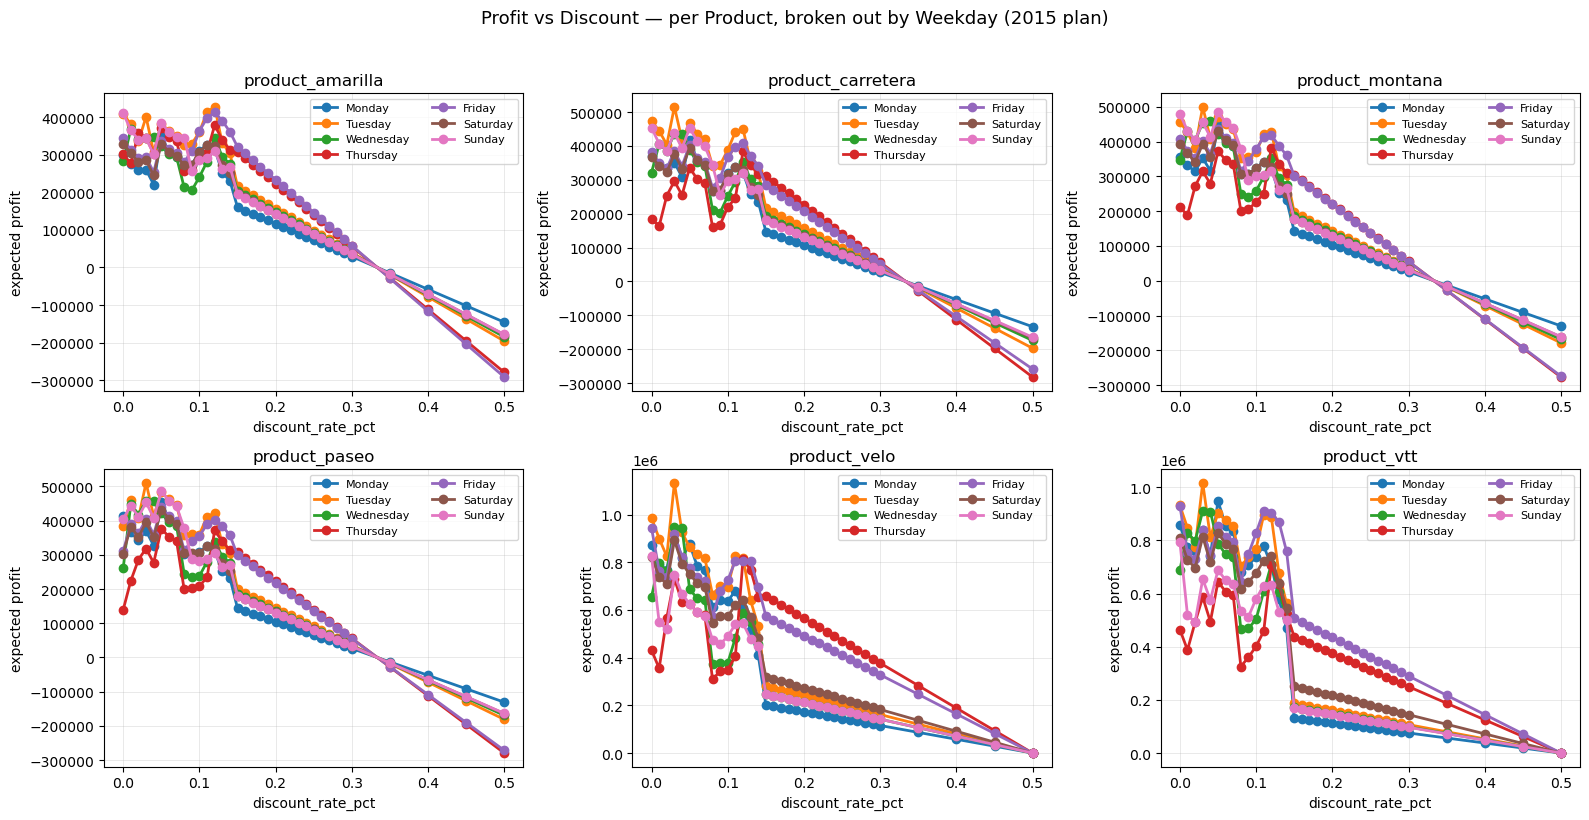

[SAVED]
Curves CSV → plots_profit_curves_by_product_weekday\profit_curves_by_product_weekday.csv
PNGs → plots_profit_curves_by_product_weekday


In [59]:
# ==== Profit vs Discount, per PRODUCT × WEEKDAY (line charts) ====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Fallbacks (use your existing ones if already defined) ----------
try:
    discount_grid
except NameError:
    MIN_DISC = globals().get("MIN_DISC", 0.00)
    MAX_DISC = globals().get("MAX_DISC", 0.50)
    STEP_COARSE = globals().get("STEP_COARSE", 0.05)
    def discount_grid(step=None):
        step = STEP_COARSE if step is None else step
        n = int(round((MAX_DISC - MIN_DISC)/step)) + 1
        return np.linspace(MIN_DISC, MAX_DISC, n)

try:
    expected_profit
except NameError:
    def expected_profit(units, price, cost, disc):
        return float(units) * max(price*(1.0 - float(disc)) - float(cost), 0.0)

# ---------- Config ----------
OUT_DIR = "plots_profit_curves_by_product_weekday"
os.makedirs(OUT_DIR, exist_ok=True)
DGRID = discount_grid()  # use STEP_FINE if you want a smoother curve

# Weekday order (filter to what's actually present in `future`)
WEEK_ORDER = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
present_weekdays = [w for w in WEEK_ORDER if w in future[DAYNAME_COL].unique().tolist()]

PRODUCTS = list(np.sort(historical[PRODUCT_COL].dropna().unique()))

# ---------- Compute curves: full-year profit at each discount, by product × weekday ----------
curves = []  # rows for CSV
by_prod = {} # product -> dict(weekday -> (dgrid, profit_vector, best_d, best_profit))

for prod in PRODUCTS:
    by_prod[prod] = {}
    for wday in present_weekdays:
        seg = future[(future[PRODUCT_COL] == prod) & (future[DAYNAME_COL] == wday)].copy()
        if seg.empty:
            continue

        # Base features & arrays
        X_base = seg[FEATS].copy()
        listp  = seg[LIST_PRICE_COL].to_numpy(dtype=float)
        cost   = seg[UNIT_COST_COL].to_numpy(dtype=float)

        prof_vec = []
        for d in DGRID:
            X = X_base.copy()
            X[DISCOUNT_COL] = float(d)
            yhat = pipe.predict(X)
            yhat = np.maximum(yhat, 0.0)

            eff_price = listp * (1.0 - float(d))
            profit = (eff_price - cost) * yhat
            prof_vec.append(np.sum(profit))   # full-year expected profit at this discount

        prof_vec = np.asarray(prof_vec)
        j = int(np.argmax(prof_vec))
        best_d = float(DGRID[j]); best_p = float(prof_vec[j])
        by_prod[prod][wday] = (DGRID, prof_vec, best_d, best_p)

        # for CSV
        for d, p in zip(DGRID, prof_vec):
            curves.append({
                "product": prod,
                "weekday": wday,
                "discount_rate_pct": float(d),
                "expected_profit": float(p)
            })

# ---------- Save tidy CSV of all curves ----------
curve_df = pd.DataFrame(curves)
csv_path = os.path.join(OUT_DIR, "profit_curves_by_product_weekday.csv")
curve_df.to_csv(csv_path, index=False)

# ---------- Plot small multiples: one subplot per product, 1 line per weekday ----------
n = len(PRODUCTS)
ncols = min(3, max(1, n))
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols + 1, 4*nrows), squeeze=False)

for idx, prod in enumerate(PRODUCTS):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]
    if prod not in by_prod or not by_prod[prod]:
        ax.set_title(str(prod) + " (no 2015 rows)")
        ax.axis("off")
        continue

    for wday in present_weekdays:
        if wday not in by_prod[prod]:
            continue
        dgrid, prof, best_d, best_p = by_prod[prod][wday]
        ax.plot(dgrid, prof, marker="o", linewidth=2, label=wday)
        # mark best point for this weekday
        ax.scatter([best_d], [best_p], s=25)

    ax.set_title(str(prod))
    ax.set_xlabel("discount_rate_pct")
    ax.set_ylabel("expected profit")
    ax.grid(True, linewidth=0.4, alpha=0.5)
    ax.legend(fontsize=8, ncol=2)

# Hide any leftover blank axes
for i in range(n, nrows*ncols):
    r, c = divmod(i, ncols)
    axes[r][c].axis("off")

fig.suptitle("Profit vs Discount — per Product, broken out by Weekday (2015 plan)", y=1.02, fontsize=13)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "profit_curves_by_product_weekday_small_multiples.png"),
            dpi=220, bbox_inches="tight")
plt.show()

print("[SAVED]")
print("Curves CSV →", csv_path)
print("PNGs →", OUT_DIR)
